In [1]:
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp
import pickle
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import sentiwordnet as swn

from data_exploration import process_articles, article_topics_and_topic_coverage

def get_sentiment(word):
    mean_pos = 0
    mean_neg = 0
    mean_obj = 0
    score = 0
    bias = 0
    for similar_words in swn.senti_synsets(word):
        mean_pos += similar_words.pos_score()
        mean_neg += similar_words.neg_score()
        mean_obj += similar_words.obj_score()
    size = len(list(swn.senti_synsets(word)))
    if size != 0:
        mean_pos = mean_pos/size
        mean_neg = mean_neg/size
        mean_obj = mean_obj/size
        score = (mean_pos - mean_neg)*(1-mean_obj)
        bias = (mean_pos + mean_neg) * (1-mean_obj)
    return mean_pos, mean_neg, mean_obj, score, bias

def sentiment(lda_model, sentiment_texts):
    lda_topics = lda_model.show_topics(num_topics=-1, num_words=10000,formatted=False)

    # We only want adjectives, verbs, adverbs
    relevant_types = ['JJ', 'VB', 'RB']

    # Get all the unique words found in each topic
    topic_words = []
    for word_and_prob in lda_topics[0][1]:
        word = word_and_prob[0]
        for word, word_type in nltk.pos_tag([word]):
            if word_type in relevant_types:
                topic_words.append(word)

    # Get list of unique words found in sentiment texts created in data_exploration.py
    sentiment_texts_words = set()
    for i in range(len(sentiment_texts)):
        sentiment_texts_words = sentiment_texts_words | set(sentiment_texts[i])
    sentiment_texts_words = list(sentiment_texts_words)

    # Get the sentiment for all words from sentiment_texts
    sentiment_of_words = dict()
    for word in sentiment_texts_words:
        if word in topic_words:
            pos, neg, obj, score, bias = get_sentiment(word)
            if pos == 0 and neg == 0:
                pass
            else:
                sentiment_of_words[word] = [pos, neg, obj, score, bias]

    return sentiment_of_words

def get_sentiment_by_article(lda_topics, sentiment_of_words, article_topic):
    sentiment_by_topic = dict()
    max_prob = 0
    for topic_and_prob in article_topic:
        topic = topic_and_prob[0]
        topic_prob = topic_and_prob[1]
        s_pos = 0
        s_neg = 0
        s_obj = 0
        s_score = 0
        s_bias = 0
        relevant_word_count = 0
        for words_and_probs in lda_topics[topic][1]:
            word = words_and_probs[0]
            if word in sentiment_of_words.keys():
                relevant_word_count += 1
                prob = words_and_probs[1]
                if prob > max_prob:
                    max_prob = prob
                pos, neg, obj, score, bias = sentiment_of_words[word]
                s_pos += pos
                s_neg += neg
                s_obj += obj
                s_score += score * prob #weight word depending on prob for that topic
                s_bias += bias * prob

        # s_pos /= max_prob
        # s_neg /= max_prob
        # s_obj /= max_prob
        s_score /= max_prob
        s_bias /= max_prob

        if relevant_word_count != 0:
            sentiment_by_topic[topic] = [topic_prob, max_prob, s_pos/relevant_word_count, s_neg/relevant_word_count, s_obj/relevant_word_count, s_score/relevant_word_count, s_bias/relevant_word_count]

    return sentiment_by_topic

def topic_values(sentiment_by_article, num_topics):
    topic_dict = {topic: {'x': [], 'y': [], 'url': [], 'source': [], 'headline': [], 'topic_prob': [], 'score': [], 'bias': []} for topic in range(num_topics)}
    for topic in range(num_topics):
        for i, sentiment_by_topic in enumerate(sentiment_by_article):
            if topic in sentiment_by_topic:
                if sentiment_by_topic[topic][0] > 0.20:
                    max_prob = sentiment_by_topic[topic][1]
                    topic_dict[topic]['x'].append(sentiment_by_topic[topic][2]/sentiment_by_topic[topic][1])
                    topic_dict[topic]['y'].append(sentiment_by_topic[topic][3]/sentiment_by_topic[topic][1])
                    topic_dict[topic]['url'].append(df['url'][i])
                    topic_dict[topic]['source'].append(df['source'][i])
                    topic_dict[topic]['headline'].append(df['headline'][i])
                    topic_dict[topic]['topic_prob'].append(sentiment_by_topic[topic][0])
                    topic_dict[topic]['score'].append(sentiment_by_topic[topic][5])

    return topic_dict

[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('../data/rss_feeds_new_good.csv')
df = df[pd.notnull(df['article_text'])]

print('Processing Articles...')
topic_texts, sentiment_texts = process_articles(df)

print('Getting LDA model...')
with open('../working_with_data/lda_model.pkl', 'rb') as f:
    lda_model = pickle.load(f)

print('Getting Sentiment...')
sentiment_of_words = sentiment(lda_model, sentiment_texts)

lda_topics = lda_model.show_topics(num_topics=-1, num_words=10000,formatted=False)

def wrapper_get_sentiment_by_article(article_topic):
    return get_sentiment_by_article(lda_topics, sentiment_of_words, article_topic)

print('Getting article topics...')
all_article_topics = article_topics_and_topic_coverage(lda_model, topic_texts, tokenized=False)


Processing Articles...
Getting LDA model...
Getting Sentiment...
Getting article topics...


In [ ]:
print('Getting Sentiment by Article using MutiProcessing...')
pool = mp.Pool(50)
test = pool.map(wrapper_get_sentiment_by_article, all_article_topics[:100])

In [ ]:
test2 = []
for at in all_article_topics[:100]:
    test2.append(get_sentiment_by_article(lda_topics, sentiment_of_words, at))

In [9]:
%matplotlib inline

In [ ]:
plt.scatter(topic_dict[27]['x'], topic_dict[27]['y'])

In [5]:
def article_sentiment(article, sentiment_of_words):
    s_pos = 0
    s_neg = 0
    s_obj = 0
    relevant_word_count = 0
    for word in article:
        if word in sentiment_of_words.keys():
            relevant_word_count += 1
            pos, neg, obj, score, bias = sentiment_of_words[word]
            s_pos += pos
            s_neg += neg
            s_obj += obj
    if relevant_word_count != 0:
         s_pos, s_neg, s_obj = s_pos/relevant_word_count, s_neg/relevant_word_count, s_obj/relevant_word_count

    return s_pos, s_neg, s_obj

In [8]:
articles_sentiment = []
for article in sentiment_texts:
    articles_sentiment.append(article_sentiment(article, sentiment_of_words))

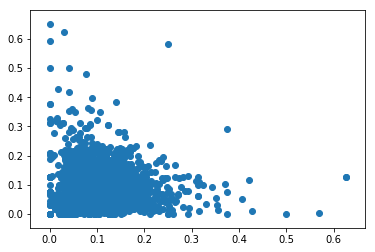

In [11]:
plt.scatter(np.array(articles_sentiment)[:,0], np.array(articles_sentiment)[:,1])

In [17]:
def topic_values(sentiment_texts, sentiment_of_words, num_topics):
    topic_dict = {topic: {'pos': [], 'neg': [], 'obj': [], 'topic_prob': [], 'url': [], 'source': [], 'headline': []} for topic in range(num_topics)}
    for i in range(len(sentiment_texts)):
        # Make sure article is long enough
        if len(sentiment_texts[i]) > 100:
            pos, neg, obj = article_sentiment(sentiment_texts[i], sentiment_of_words)
            for topic_and_prob in all_article_topics[i]:
                topic = topic_and_prob[0]
                prob = topic_and_prob[1]
                if prob > 0.20:
                    topic_dict[topic]['pos'].append(pos)
                    topic_dict[topic]['neg'].append(neg)
                    topic_dict[topic]['obj'].append(neg)
                    topic_dict[topic]['topic_prob'].append(prob)
                    topic_dict[topic]['url'].append(df['url'][i])
                    topic_dict[topic]['source'].append(df['source'][i])
                    topic_dict[topic]['headline'].append(df['headline'][i])

    return topic_dict

In [18]:
topic_dict_values = topic_values(sentiment_texts, sentiment_of_words, lda_model.num_topics)

{'headline': ['Biden to headline Romney summit',
  'Exclusive: EPA offers buyouts in bid to cut staff - internal memo',
  'AP Source: Flynn agrees to provide some requested documents',
  'Al Franken to David Letterman: ‘Everything points to’ collusion with Trump, Russia',
  'AP source: Flynn agrees to provide documents to Senate panel',
  'The Latest: Flynn to give documents to Senate intel panel',
  "Congress expands Russia investigation to include Trump's personal attorney",
  "Report: Michael Flynn's firm worked on pro-Turkey documentary for $530K",
  'Trump lawyer, former Trump surrogate on list of people House committee wants to hear from',
  "Trump lawyer Michael Cohen won't cooperate with Congress",
  'Jeb Bush no longer interested in buying Miami Marlins',
  "U.S. senators criticize Egypt's NGO law as crackdown on rights",
  'Flynn to turn over subpoenaed documents to Senate intelligence committee',
  "Flynn's firm was paid $530G to make pro-Turkey documentary last fall",
  "Ho